## **Assignment 2**
**Noorah Alkhaniny** 
🐪


First I will download the data form Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noorahalkhaniny","key":"185d2c4e87b0a1eecf0ae22d9ed34ccc"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats


 95% 257M/271M [00:01<00:00, 177MB/s]
100% 271M/271M [00:01<00:00, 156MB/s]
 98% 533M/543M [00:03<00:00, 161MB/s]
100% 543M/543M [00:03<00:00, 153MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 89.9MB/s]


In [5]:
!unzip -qq train.zip


Using 1000 set for training, validation at 500 and test at 500

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Model building**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 3)      12        
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 178, 178, 128)    539       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 128)      0         
 )                                                               
                                                             

using "adam" to optimize the model

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [13]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [15]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the data

In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
32/32 [==============================] - 290s 9s/step - loss: 1.0260 - accuracy: 0.5655 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 2/10
32/32 [==============================] - 276s 9s/step - loss: 0.5501 - accuracy: 0.7270 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 3/10
32/32 [==============================] - 283s 9s/step - loss: 0.4469 - accuracy: 0.8040 - val_loss: 0.6925 - val_accuracy: 0.5090
Epoch 4/10
32/32 [==============================] - 284s 9s/step - loss: 0.3676 - accuracy: 0.8520 - val_loss: 0.6885 - val_accuracy: 0.5450
Epoch 5/10
32/32 [==============================] - 285s 9s/step - loss: 0.2972 - accuracy: 0.8810 - val_loss: 0.6799 - val_accuracy: 0.6180
Epoch 6/10
32/32 [==============================] - 289s 9s/step - loss: 0.1742 - accuracy: 0.9505 - val_loss: 0.6689 - val_accuracy: 0.6030
Epoch 7/10
32/32 [==============================] - 286s 9s/step - loss: 0.1161 - accuracy: 0.9740 - val_loss: 0.6535 - val_accuracy: 0.6230
Epoch 8/10
32

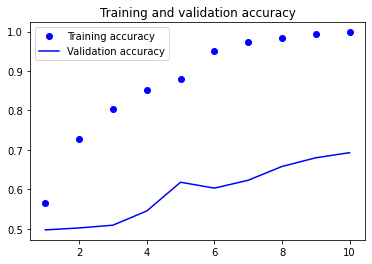

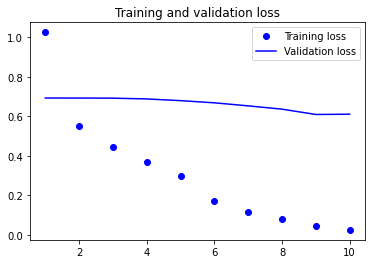

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 31s 2s/step - loss: 0.6257 - accuracy: 0.6780
Test accuracy: 0.678


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using data augmentation and image model


In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

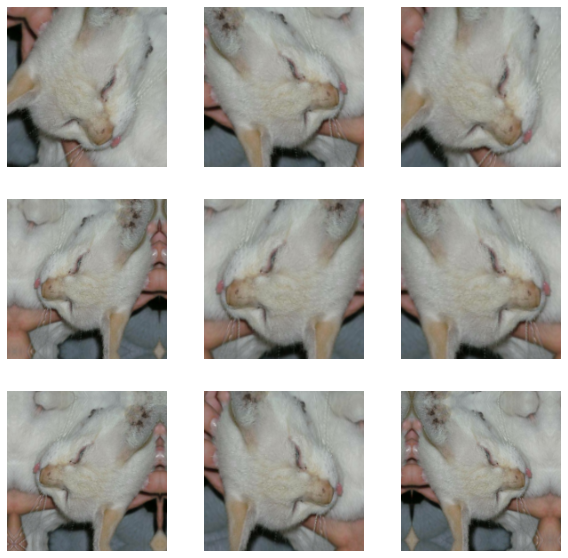

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
32/32 [==============================] - 222s 6s/step - loss: 0.6926 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.5140
Epoch 2/10
32/32 [==============================] - 193s 6s/step - loss: 0.6886 - accuracy: 0.5450 - val_loss: 0.6879 - val_accuracy: 0.5640
Epoch 3/10
32/32 [==============================] - 187s 6s/step - loss: 0.6873 - accuracy: 0.5600 - val_loss: 0.6884 - val_accuracy: 0.5540
Epoch 4/10
32/32 [==============================] - 191s 6s/step - loss: 0.6907 - accuracy: 0.5365 - val_loss: 0.6965 - val_accuracy: 0.5300
Epoch 5/10
32/32 [==============================] - 182s 6s/step - loss: 0.6783 - accuracy: 0.5735 - val_loss: 0.6640 - val_accuracy: 0.5940
Epoch 6/10
32/32 [==============================] - 180s 6s/step - loss: 0.6709 - accuracy: 0.6130 - val_loss: 0.6483 - val_accuracy: 0.6350
Epoch 7/10
32/32 [==============================] - 183s 6s/step - loss: 0.6359 - accuracy: 0.6435 - val_loss: 0.6492 - val_accuracy: 0.6190
Epoch 8/10
32

In [26]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64)


import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(64)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(64, 16)
(64, 16)
(64, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)
Epoch 1/10
47/47 [==============================] - 443s 9s/step - loss: 0.8602 - accuracy: 0.5783 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 457s 10s/step - loss: 0.5444 - accuracy: 0.7220 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 3/10
47/47 [==============================] - 456s 10s/step - loss: 0.4188 - accuracy: 0.8143 - val_loss: 0.6903 - val_accuracy: 0.5990
Epoch 4/10
47/47 [==============================] - 451s 10s/step - loss: 0.2921 - accuracy: 0.8940 - val_loss: 0.6742 - val_accuracy: 0.6240
Epoch 5/10
47/47 [==============================] - 438s 9s/step - loss: 0.2060 - accuracy: 0.9210 - val_loss: 0.6348 - val_accuracy: 0.7120
Epoch 6/10
47/47 [=======================

In [28]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 60s 2s/step - loss: 0.6300 - accuracy: 0.7040
Test accuracy: 0.704


Since I increased the size of the dataset, we can see that the validation accuracy has increased also to 70%

**Using pretrained network**

In [29]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 6.1038 - accuracy: 0.9503 

validation accuracy is preferming much better 😁 💪

**Test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")